In [1]:
import numpy as np
import matplotlib.pyplot as plt

# A simple example built from scratch
After https://github.com/Joseph94m

## Step 1: Data generation

We generate 30,000 samples from a normal distribution with mean μ= 10, and standard deviation σ= 3, but we can only observe 1000 random samples from them.

9.947966909693426

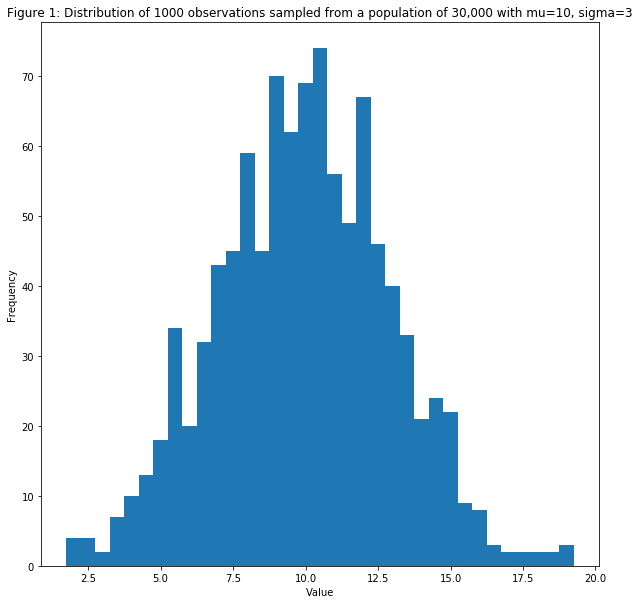

In [2]:
mod1=lambda t:np.random.normal(10,3,t)

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with mu=10, sigma=3")
mu_obs=observation.mean()
mu_obs

## Step 2: Define what you want

We would like to find a distribution for $\sigma\text{{observed}}$ using the 1000 observed samples. We will not estimate the distribution of $\mu$ to keep this example simple, but simply assume $\mu\text{{observed}} = 9.8$.

## Step 3: Define the PDF and the transition model

### For the transition model/ proposal distribution

The Metropolis-Hastings algorithm uses the transition model Q to randomly walk in the distribution space, accepting or rejecting jumps to new positions based on how likely the sample is. This “memoriless” random walk is the “Markov Chain” part of MCMC. To get a new position of the parameter, just take our current one, θ, and propose a new one , θ’, that is a random sample drawn from Q(θ'/θ). Often this is a symmetric distribution. For instance, a normal distribution with mean θ and some standard deviation σ: Q(θ'/θ) = N(θ, σ). Since we have no specific distribution in mind, let's choose a simple one: the normal distribution!

In [3]:
#The tranistion model defines how to move from sigma_current to sigma_new
Q = lambda x: [x[0],np.random.normal(x[1],1,1)]
print(Q(np.array([2,1])))

[2, array([0.65065119])]


### For the PDF

The “likelihood” of each new sample is decided by a function f . That’s why f must be proportional to the posterior we want to sample from. f is commonly chosen to be a probability density function that expresses this proportionality. $f(d_i|\theta)$ expresses the likelihood of each data point $d_i$ in the data set D in light of the sampled model parameters $\theta = [\mu_{\text{obs}},\sigma]$.

## Step 4: Define when we accept or reject a sampled parameter $\sigma\text{{new}}$

### Define the acceptance formula

Accept $\theta_{\text{new}}$ if,
$$\frac{\text{Liklihood}(D | \mu_{\text{obs}},\sigma_{\text{new}})*\text{prior}(\mu_{\text{obs}},\sigma_{\text{new}})}{\text{Liklihood}(D | \mu_{\text{obs}},\sigma_{\text{old}})*\text{prior}(\mu_{\text{obs}},\sigma_{\text{old}})} > 1 $$

If this ratio is not larger than 1, then we compare it to a uniformly generated random number in the closed set [0,1]. If the ratio is larger than the random number, we accept $\sigma_{\text{new}}$, otherwise we reject it. This ensures that even if a sample is less likely than the current, we might still want to try it.

### The Likelihood $\text{L}(\text{D}|\mu_{\text{obs}},\sigma_{\text{new}})$

We've already the defined the liklihood of a single datapoint $d_i$ given a set of sampled parameters. The total likelihood for a set of observation D is simply the product of $f(d_i|\theta)$ over all datapoints. However, we want to take the logarithm of both the prior and the likelihood function to avoid an underflow in the system’s memory.

In [4]:
#Computes the likelihood of the data given a sigma (new or current)
def L(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

### The Prior $\text{P}(\mu,\sigma)$

We don’t have any preferences for the values that $\sigma{\text{new}}$ and $\sigma{\text{old}}$ can take. The only thing worth noting is that they should be positive. 

In [5]:
def P(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

### The acceptance formula revisited

Accept $\theta_{\text{new}}$ if,
$$\text{log} \Bigg( \frac{\text{L}(D | \mu_{\text{obs}},\sigma_{\text{new}})*\text{P}(\mu_{\text{obs}},\sigma_{\text{new}})}{\text{L}(D | \mu_{\text{obs}},\sigma_{\text{old}})*\text{P}(\mu_{\text{obs}},\sigma_{\text{old}})} \Bigg) > \text{log}(1) $$

$$\frac{\text{log}\big(\text{L}(D | \mu_{\text{obs}},\sigma_{\text{new}})*\text{P}(\mu_{\text{obs}},\sigma_{\text{new}})\big)}{\text{log}\big(\text{L}(D | \mu_{\text{obs}},\sigma_{\text{old}}*\text{P}(\mu_{\text{obs}},\sigma_{\text{old}})\big)} > 0 $$

$$\text{log}\big(\text{L}(D | \mu_{\text{obs}},\sigma_{\text{new}})\big) + \text{log}\big( \text{P}(\mu_{\text{obs}},\sigma_{\text{new}})\big) - \text{log}\big(\text{L}(D | \mu_{\text{obs}},\sigma_{\text{old}}\big) - \text{log}\big(\text{P}(\mu_{\text{obs}},\sigma_{\text{old}})\big) > 0$$

In [6]:
#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))

## Step 5: Implement the metropolis hastings algorithm

In [7]:
def metropolis_hastings(L,P,Q,acceptance,initial,data,n=100):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = initial
    accepted = []
    rejected = []   
    for i in range(n):
        x_new =  Q(x)    
        x_lik = L(x,data)
        x_new_lik = L(x_new,data) 
        if (acceptance(x_lik + np.log(P(x)),x_new_lik+np.log(P(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

## Step 6: Run the algorithm and visualise

In [8]:
accepted,rejected=metropolis_hastings(L,P,Q,acceptance,[mu_obs,0.1],observation,n=1000)

<ipython-input-4-a79697d12b72>:5: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))
<ipython-input-7-e0fad005dc99>:15: RuntimeWarning: divide by zero encountered in log
  if (acceptance(x_lik + np.log(P(x)),x_new_lik+np.log(P(x_new)))):


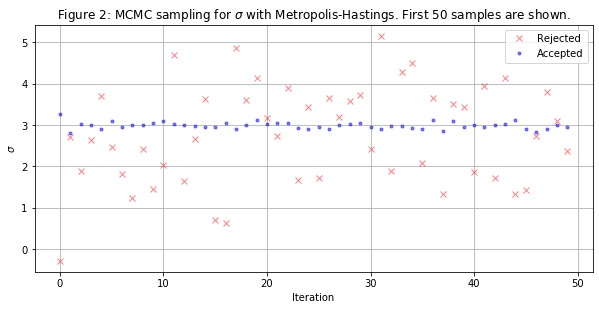

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()

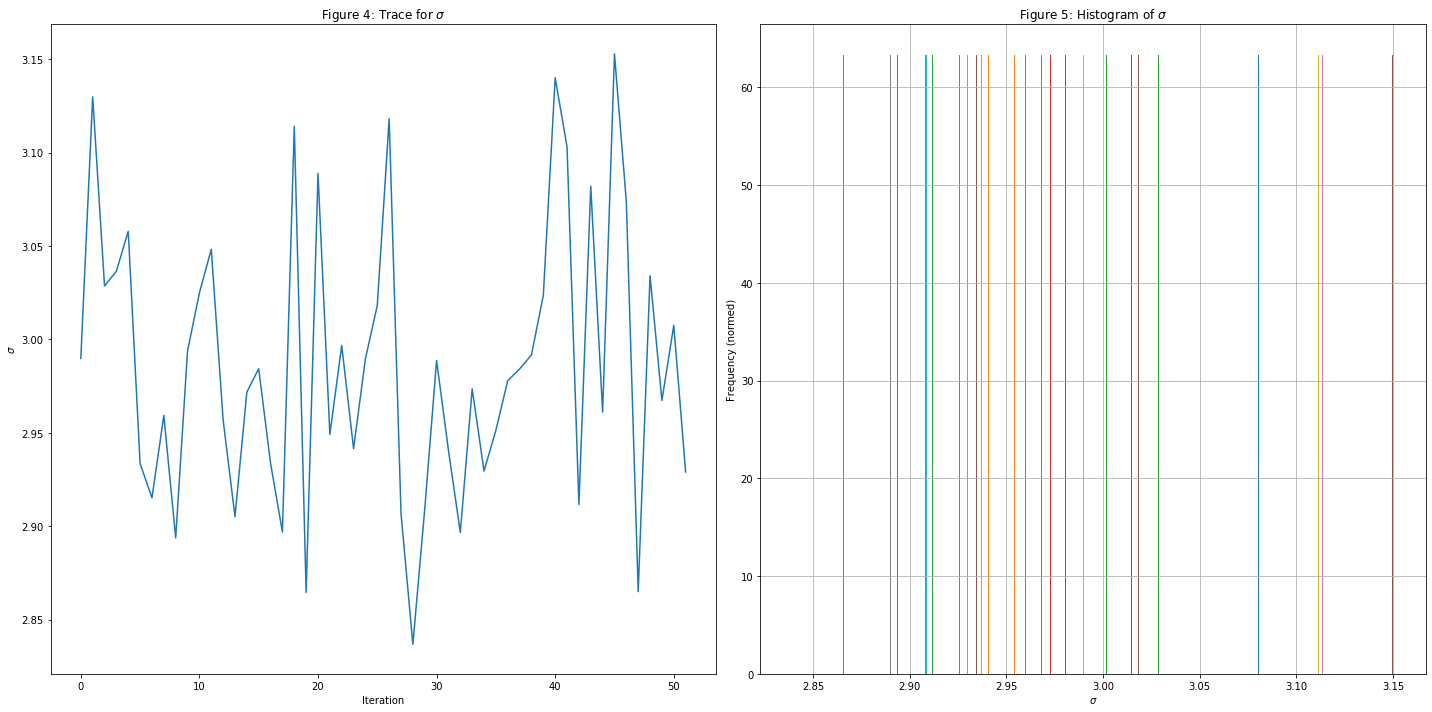

In [10]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()
ax.grid("off")

# Application to the UGent COVID-19 Model

### Load the BIOMATH Covid-19 model and data

In [70]:
from covid19model.models import models

In [71]:
# Load interaction matrices
Nc_home = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELhome.txt", dtype='f', delimiter='\t')
Nc_work = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELwork.txt", dtype='f', delimiter='\t')
Nc_schools = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELschools.txt", dtype='f', delimiter='\t')
Nc_transport = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELtransport.txt", dtype='f', delimiter='\t')
Nc_leisure = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELleisure.txt", dtype='f', delimiter='\t')
Nc_others = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELothers.txt", dtype='f', delimiter='\t')
Nc_total = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELtotal.txt", dtype='f', delimiter='\t')
initN = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELagedist_10year.txt", dtype='f', delimiter='\t')

In [72]:
ageModel = models.SEIRSAgeModel(initN   = initN,         #16x0 numpy array
                                     beta    = 0.04, # probability of infection when encountering infected person
                                     sigma   = 3.2, # latent period
                                     omega   = 2.0, # pre-symptomatic infectious period
                                     Nc = Nc_total, #must be a numpy array; average number of human-to-human interactions per day
                                     a = 0.43, # probability of an asymptotic (supermild) infection
                                     m = 1-0.43, # probability of a mild infection
                                     h =np.array([[0.0205,0.0205,0.1755,0.1755,0.2115,0.2503,0.3066,0.4033,0.4770]]), # probability of hospitalisation for a mild infection
                                     c = 1- np.array([0,0,0.0310,0.0310,0.055,0.077,0.107,0.1685,0.1895]), # probability of hospitalisation in cohort
                                     mi = 0.5*np.array([0,0,0.0310,0.0310,0.055,0.077,0.107,0.1685,0.1895]), # probability of hospitalisation in midcare
                                     da = 7, # days of infection when asymptomatic (supermild)
                                     dm = 7, # days of infection when mild
                                     dc = 7,
                                     dmi = 14,
                                     dICU = 14,
                                     dICUrec = 7,
                                     dmirec = 7,
                                     dhospital = 4, # days before reaching the hospital when heavy or critical
                                     #m0 = np.transpose(np.array([0.000094,0.00022,0.00091,0.0018,0.004,0.013,0.046,0.098,0.18])), # mortality in ICU
                                     m0 = np.ones(9)*0.50,
                                     maxICU = 2000,
                                     totalTests = 0,
                                     psi_FP = 0, # probability of a false positive
                                     psi_PP = 1, # probability of a correct test
                                     dq = 14, # days in quarantaine                          
                                     initE = np.ones(9), #must be a numpy array
                                     initI = np.zeros(9),
                                     initA = np.zeros(9), 
                                     initM = np.zeros(9),
                                     initC = np.zeros(9),
                                     initCmirec = np.zeros(9),
                                     initCicurec = np.zeros(9),
                                     initMi = np.zeros(9),
                                     initICU = np.zeros(9),
                                     initR = np.zeros(9),
                                     initD = np.zeros(9),
                                     initSQ = np.zeros(9),
                                     initEQ = np.zeros(9),
                                     initIQ = np.zeros(9),
                                     initAQ = np.zeros(9),
                                     initMQ = np.zeros(9),
                                     initRQ = np.zeros(9),
                                     monteCarlo = False,
                                     n_samples = 100,
                            )

In [73]:
[index,data] = model.obtainData()
ICUvect = np.transpose(data[0])
hospital = np.transpose(data[1])
print(ICUvect.shape)

(1, 63)


### Use pyMC3

In [74]:
import pymc3 as pm
import theano.tensor as tt
from theano.compile.ops import as_op

In [75]:
# set optimisation settings
data=[np.transpose(ICUvect[:,0:7]),np.transpose(hospital[:,0:7])]
parNames = ['beta'] # must be a list!
positions = [np.array([6]),np.array([4,5,6])] # must be a list!
weights = np.array([0,1])

In [79]:
@as_op(itypes=[tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def pipe2COVID19MODEL(extraTime,beta):
    ageModel.beta = beta
    T = 9+extraTime-1
    model.sim(T)
    out = np.mean(model.sumICU,axis=1)
    return out[int(extraTime):]

data=ICUvect[:,:9]

with pm.Model() as COVID19MODEL:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=0.06, sigma=0.01)
    extraTime = pm.Normal('extraTime', mu=32, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=20)
    
    mu = pipe2COVID19MODEL(extraTime,beta)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=data)

In [80]:
map_estimate = pm.find_MAP(model=COVID19MODEL, method='powell')
map_estimate

logp = -55.364: 100%|██████████| 369/369 [00:07<00:00, 49.83it/s]  


{'beta': array(0.06),
 'extraTime': array(51.),
 'sigma_log__': array(3.78341774),
 'sigma': array(43.96604956)}

In [ ]:
with COVID19MODEL:

    # draw 1000 posterior samples
    trace = pm.sample(1000,start=map_estimate,step=pm.Metropolis(),cores=1,tune=100)

pm.traceplot(trace,varnames=['beta', 'extraTime','sigma']);

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [extraTime]
>Metropolis: [beta]
Sampling chain 0, 0 divergences:  28%|██▊       | 303/1100 [00:33<01:28,  9.05it/s]

In [ ]:
pm.summary(trace)

<function matplotlib.pyplot.show(*args, **kw)>

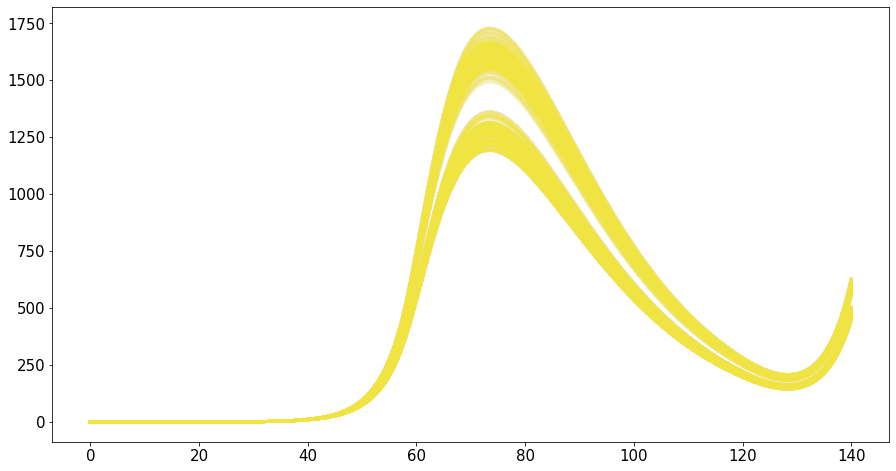

In [44]:
# Create checkpoints dictionary
chk = {'t':       [58,120], 
       'Nc':      [np.array([1]),np.array([11.2])]
      }

fig, ax = plt.subplots(figsize=(15, 8))
for i in range(len(trace['beta'])):
    model.beta = trace['beta'][i]
    # Run simulation
    y = model.sim(140,checkpoints=chk)
    ax.plot(model.tseries,model.sumICU,color=red, alpha=.001)
plt.show

https://docs.pymc.io/notebooks/ODE_with_manual_gradients.html